# 1.Predictive Modelling 

### Load & Prepare the Data

In [19]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

try:
    # Load data
    df = pd.read_csv('BDA601_Assessment 3_time_series_covid19_confirmed_global.csv')
    # Validate required columns
    required_columns = ['Province/State', 'Country/Region', 'Lat', 'Long']
    if not all(col in df.columns for col in required_columns):
        raise ValueError("Missing required columns in the dataset")

    # Melt the dataframe to convert dates from columns to rows
    id_vars = ['Province/State', 'Country/Region', 'Lat', 'Long']
    df_melted = df.melt(id_vars=id_vars, var_name='Date', value_name='Confirmed Cases')  
    df_melted['Date'] = pd.to_datetime(df_melted['Date'])

    # Group by country and date to aggregate counts at the country level
    df_grouped = df_melted.groupby(['Country/Region', 'Date'])['Confirmed Cases'].sum().reset_index()

    # Assign week numbers
    start_date = df_grouped['Date'].min()
    df_grouped['Week'] = ((df_grouped['Date'] - start_date).dt.days // 7) + 1

    # Calculate new cases (daily infections)
    df_grouped['New Cases'] = df_grouped.groupby('Country/Region')['Confirmed Cases'].diff().fillna(0)
    # Load population data
    population_df = pd.read_csv('population.csv')
    # Create a dictionary of populations for faster lookups
    population_dict = dict(zip(population_df['Country'], population_df['Population']))
  
    # Add population data to the dataframe
    df_grouped['Population'] = df_grouped['Country/Region'].map(population_dict)
    
    # Handle missing population data
    missing_countries = df_grouped[df_grouped['Population'].isna()]['Country/Region'].unique()
    if len(missing_countries) > 0:
        print(f"Countries missing population data: {missing_countries}")
    # Calculate infection rate using the epidemiological formula
    # Rate of infection = K × (number of infections / number of those at risk)
    K = 100000  # Standard multiplier for population-level rates
    df_grouped['Infection Rate'] = K * (df_grouped['New Cases'] / df_grouped['Population'])

    # For countries without population data, set infection rate to NaN
    df_grouped.loc[df_grouped['Population'].isna(), 'Infection Rate'] = float('nan')
    
except Exception as e:
    print(f"Error loading data: {str(e)}")
    raise

C:\Users\chaul\AppData\Local\Temp\ipykernel_43256\752276207.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_melted['Date'] = pd.to_datetime(df_melted['Date'])


### Select top 3 countries

Identify the top 3 countries with the highest infection rates based on the latest date.

In [20]:
# Get the latest date in the dataset
latest_date = df_grouped['Date'].max()
print(f"Latest Date : {latest_date.strftime('%d-%m-%Y')}")
# Get top 3 countries with the highest infection counts on the latest date
top_countries = df_grouped[df_grouped['Date'] == latest_date].nlargest(3, 'Confirmed Cases')['Country/Region'].tolist()
print(f"Top 3 countries: {top_countries}")


Latest Date : 03-08-2020
Top 3 countries: ['US', 'Brazil', 'India']


### Fit Linear Regression Models

For each of the top 3 countries, fit a linear regression model with Week as the independent variable and Confirmed Cases as the dependent variable.

In [21]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score

# Function to fit linear regression and calculate variance (R²)
def fit_linear_regression(country, data):
    
    # Filter data for the given country
    country_data = data[data['Country/Region'] == country]
    
    # Prepare features (Week) and target (Confirmed Cases)
    X = country_data['Week'].values.reshape(-1, 1)
    y = country_data['Confirmed Cases'].values

    # Perform cross-validation
    model = LinearRegression()
    cv_scores = cross_val_score(model, X, y, cv=5)
    
    # Fit linear regression model
    model.fit(X, y)
    
    # Predict and calculate metrics : variance explained (R²), MSE, MAE 
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y,y_pred)
    mae = mean_absolute_error(y,y_pred)

    # Calculate prediction intervals
    # 1.96 is the value from the standard normal distribution (Z-distribution) 
    # corresponding to a 95% confidence level
    std_error = np.sqrt(mse)
    conf_interval = 1.96*std_error 

    metrics = {
        'r2':r2,
        'mse':mse,
        'mae':mae,
        'cv_score_mean':cv_scores.mean(),
        'conf_interval':conf_interval
    }
    
    return model, metrics, country_data

# Fit models for the top 3 countries
models = {}
for country in top_countries:
    model, metrics, country_data = fit_linear_regression(country, df_grouped)
    models[country] = {
        'model': model,
        'metrics': metrics,
        'data': country_data
    }
    print(f"{country}:")
    print(f"R² = {metrics['r2']:.4f}")
    print(f"Cross-validation score = {metrics['cv_score_mean']:.4f}")
    print(f"Mean Absolute Error = {metrics['mae']:.4f}\n")


US:
R² = 0.8939
Cross-validation score = -12507212652.6321
Mean Absolute Error = 374823.2043

Brazil:
R² = 0.7212
Cross-validation score = -1133694878069.1274
Mean Absolute Error = 361672.1066

India:
R² = 0.6184
Cross-validation score = -36303403337.3381
Mean Absolute Error = 217742.1477



### Select the Country with the Highest Variance

In [22]:
# Find the country with the highest R²
selected_country = max(models, key=lambda x: models[x]['metrics']['r2'])
selected_metrics = models[selected_country]['metrics']

print(f"Selected Country: {selected_country}")
print(f"Highest R² = {selected_metrics['r2']:.4f}")
print(f"Cross-validation score = {selected_metrics['cv_score_mean']:.4f}")

Selected Country: US
Highest R² = 0.8939
Cross-validation score = -12507212652.6321


### Analyze the selected Model

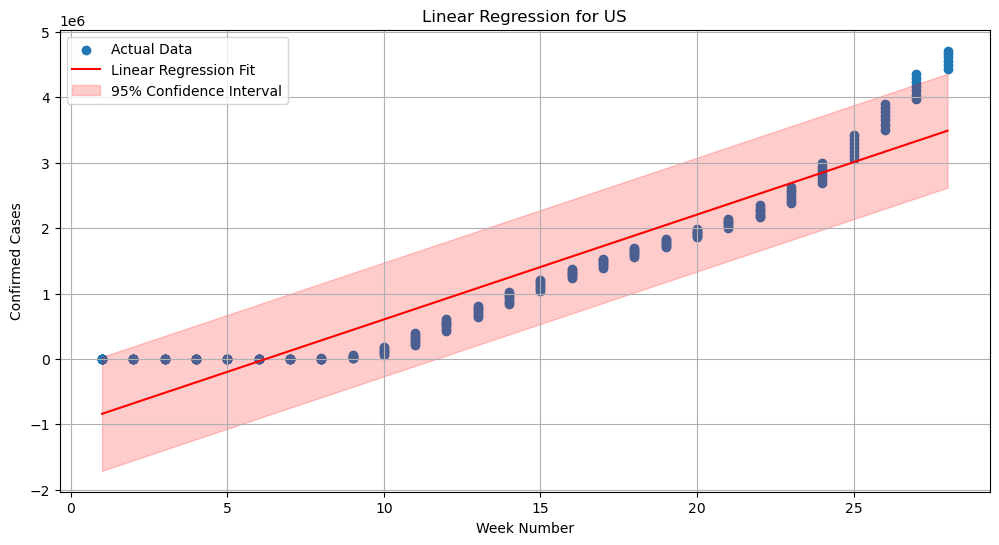

Intercept: -1000312.0105250571
Coefficient: 160358.73562629215


In [23]:
def analyze_selected_country(selected_country,selected_model,selected_data):
    
    # Visualize the linear regression for the selected country
    plt.figure(figsize=(12, 6))
    plt.scatter(selected_data['Week'], selected_data['Confirmed Cases'], label='Actual Data')
    plt.plot(selected_data['Week'], selected_model.predict(selected_data['Week'].values.reshape(-1, 1)), 
         color='red', label='Linear Regression Fit')

    y_pred = selected_model.predict(selected_data['Week'].values.reshape(-1, 1))
    plt.fill_between(selected_data['Week'],
                 y_pred - selected_metrics['conf_interval'],
                 y_pred + selected_metrics['conf_interval'],
                 alpha=0.2, color='red', label='95% Confidence Interval')

    plt.title(f'Linear Regression for {selected_country}')
    plt.xlabel('Week Number')
    plt.ylabel('Confirmed Cases')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print model coefficients
    print(f"Intercept: {selected_model.intercept_}")
    print(f"Coefficient: {selected_model.coef_[0]}")

selected_model = models[selected_country]['model']
selected_data = models[selected_country]['data']
analyze_selected_country(selected_country, selected_model, selected_data)


## 2. Clustering

### Prepare Data for Clustering

In [24]:
from sklearn.preprocessing import RobustScaler, StandardScaler

# Prepare data for the selected country
clustering_data = selected_data.copy()
clustering_data = clustering_data.dropna(subset=['Infection Rate', 'Confirmed Cases'])

# Standardize features
scaler = RobustScaler()
clustering_data[['Infection Rate', 'Confirmed Cases']] = scaler.fit_transform(clustering_data[['Infection Rate', 'Confirmed Cases']])

### Determine Optimal K
Use the Elbow Method to determine the optimal number of clusters (K) by iterating over a range of K values and plotting the inertia (within-cluster sum of squares).


Data statistics before scaling:
       Infection Rate  Confirmed Cases
count      195.000000       195.000000
mean         0.014289         0.140364
std          0.651194         0.643402
min         -0.725334        -0.477897
25%         -0.720637        -0.477470
50%          0.000000         0.000000
75%          0.279363         0.522530
max          1.638542         1.740271


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

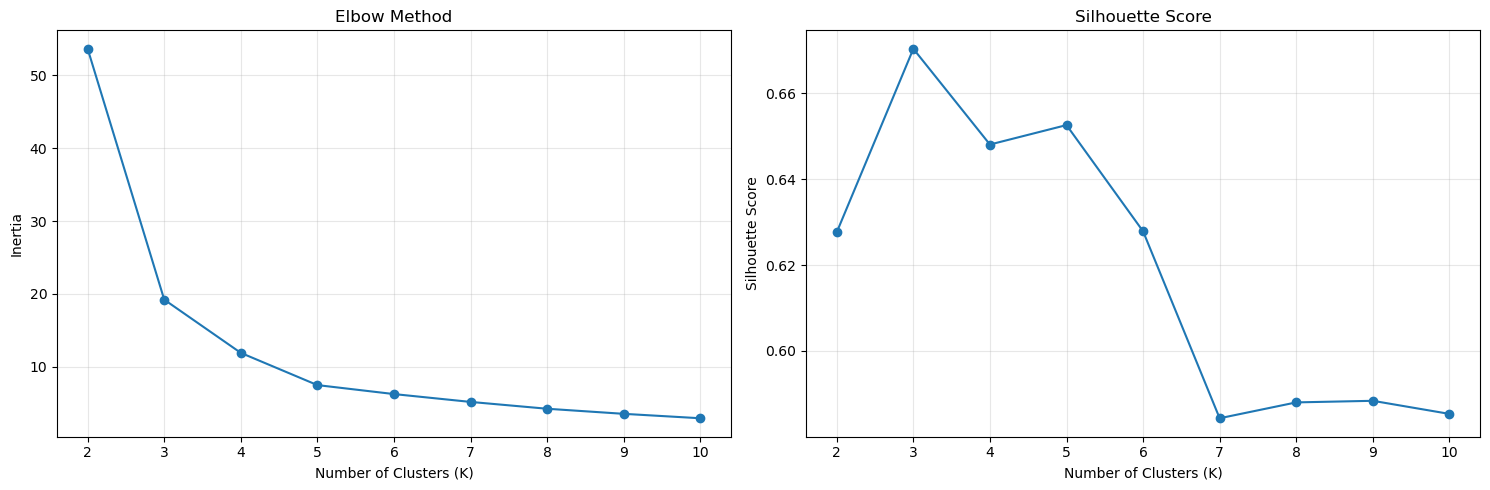

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Drop rows with NaN values
clustering_data = clustering_data.dropna(subset=['Infection Rate', 'Confirmed Cases'])

if len(clustering_data) < 2:
    raise ValueError(f"Insufficient data points for clustering after removing invalid values: {len(clustering_data)} rows")
            
# Print data statistics before scaling
print("\nData statistics before scaling:")
print(clustering_data[['Infection Rate', 'Confirmed Cases']].describe())


# Elbow Method to find the optimal K
inertia = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(clustering_data[['Infection Rate', 'Confirmed Cases']])
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(clustering_data[['Infection Rate', 'Confirmed Cases']], labels))
    

# Plot both metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(K_range, inertia, marker='o')
ax1.set_title('Elbow Method')
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Inertia')
ax1.grid(True, alpha=0.3)

ax2.plot(K_range, silhouette_scores, marker='o')
ax2.set_title('Silhouette Score')
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Perform K-Means Clustering
Once the optimal K is determined, fit the K-Means model and assign clusters to the dataset.

In [26]:
# Choose optimal K based on silhouette score
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k}")

# Fit K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clustering_data['Cluster'] = kmeans.fit_predict(clustering_data[['Infection Rate', 'Confirmed Cases']])

# Add cluster centers for visualization
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

Optimal number of clusters: 3


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### Visualize Clusters
Plot the clusters to observe trends in infection rates over time.

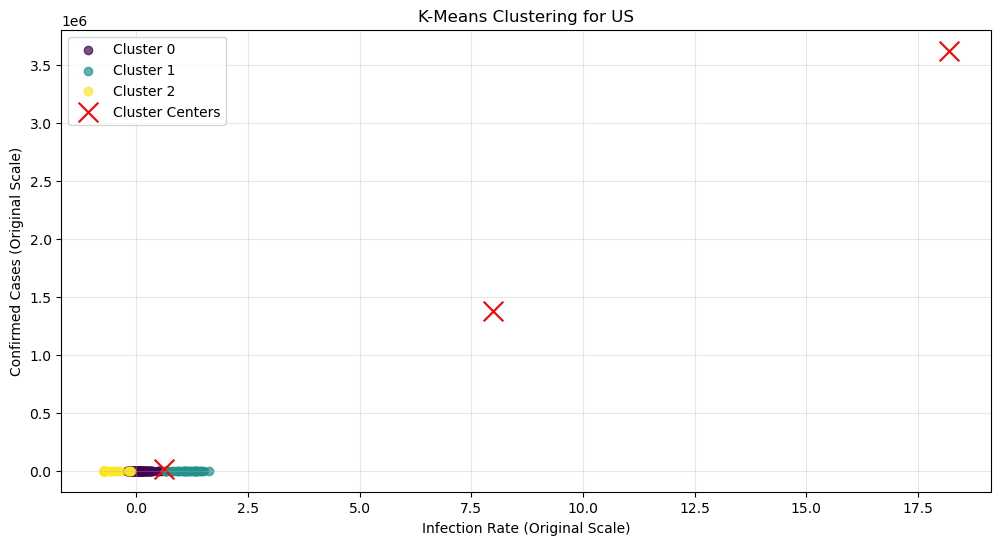

In [27]:
# Plot the clusters
plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 1, optimal_k))

for cluster, color in enumerate(colors):
    cluster_points = clustering_data[clustering_data['Cluster'] == cluster]
    plt.scatter(cluster_points['Infection Rate'], cluster_points['Confirmed Cases'], 
                color=color, label=f'Cluster {cluster}', alpha=0.7)

# Plot cluster centers
cluster_centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(cluster_centers_original[:, 0], cluster_centers_original[:, 1], 
            color='red', marker='x', s=200, label='Cluster Centers')

plt.title(f'K-Means Clustering for {selected_country}')
plt.xlabel('Infection Rate (Original Scale)')
plt.ylabel('Confirmed Cases (Original Scale)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [28]:
cluster_counts = clustering_data['Cluster'].value_counts()
print(f"Cluster Counts:\n{cluster_counts}\n")

for cluster in sorted(clustering_data['Cluster'].unique()):
    subset = clustering_data[clustering_data['Cluster'] == cluster]
    print(f"Cluster {cluster} Summary:")
    print(subset.describe())
    print("\n")

Cluster Counts:
Cluster
0    91
2    68
1    36
Name: count, dtype: int64

Cluster 0 Summary:
                                Date  Confirmed Cases       Week  \
count                             91        91.000000  91.000000   
mean   2020-05-14 00:47:28.351648256         0.169256  16.714286   
min              2020-03-30 00:00:00        -0.401329  10.000000   
25%              2020-04-21 12:00:00        -0.090424  13.500000   
50%              2020-05-14 00:00:00         0.192101  17.000000   
75%              2020-06-05 12:00:00         0.423420  20.000000   
max              2020-06-29 00:00:00         0.741258  23.000000   
std                              NaN         0.312502   3.789710   

          New Cases   Population  Infection Rate  Cluster  
count     91.000000         91.0       91.000000     91.0  
mean   26419.868132  331002651.0        0.083070      0.0  
min    17355.000000  331002651.0       -0.194300      0.0  
25%    22006.500000  331002651.0       -0.051971     

## 3. Analytics Data of neighboring countries

- Identify neighboring countries
- Group the data by country and week to calculate weekly infection counts.

In [29]:
neighboring_countries=['Mexico', 'Canada']
print(neighboring_countries)

['Mexico', 'Canada']


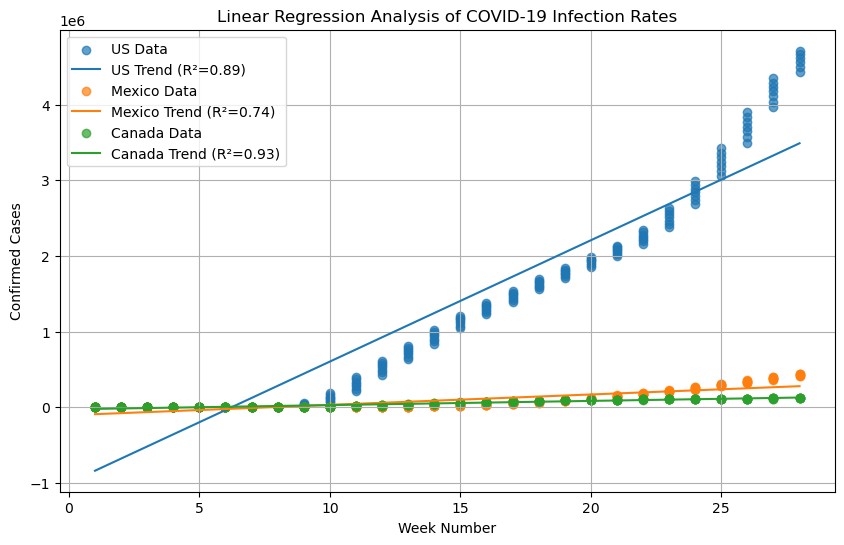

In [30]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for country in [selected_country]+neighboring_countries:
    country_data = df_grouped[df_grouped['Country/Region'] == country]
    model, metrics, country_data = fit_linear_regression(country, df_grouped)

    plt.scatter(country_data['Week'], country_data['Confirmed Cases'], label=f"{country} Data", alpha=0.7)
    plt.plot(country_data['Week'], model.predict(country_data['Week'].values.reshape(-1, 1)), 
             label=f"{country} Trend (R²={metrics['r2']:.2f})")

plt.title('Linear Regression Analysis of COVID-19 Infection Rates')
plt.xlabel('Week Number')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.grid()
plt.show()

Compare weekly infection trends of the selected country and its neighbors to identify patterns or correlations.

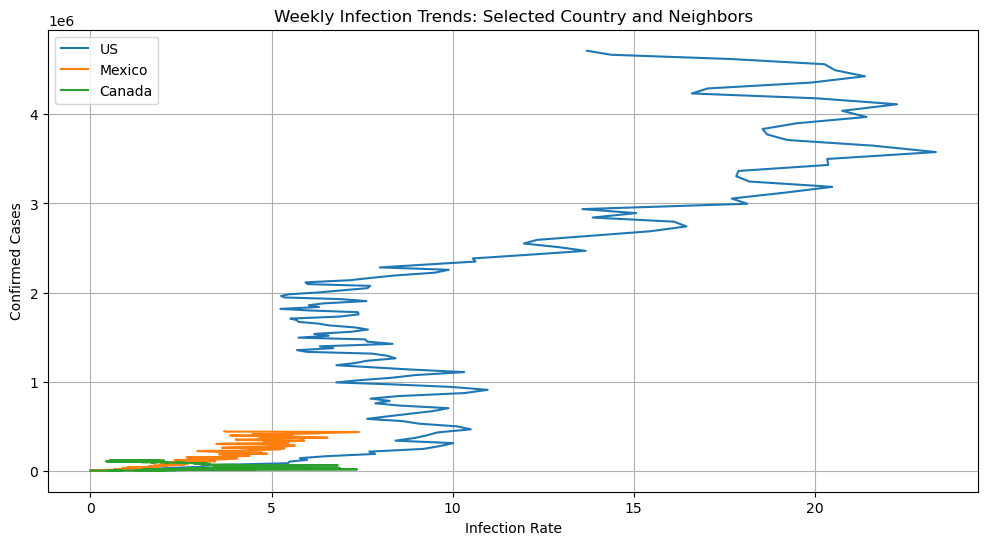

In [31]:
# Extract weekly infection data for the selected country
selected_country_data = df_grouped[df_grouped['Country/Region'] == selected_country]

# Extract weekly infection data for neighboring countries
neighbors_weekly_data = df_grouped[df_grouped['Country/Region'].isin(neighboring_countries)]

# Merge weekly infection data for all countries
merged_data = pd.concat([selected_country_data, neighbors_weekly_data])

# Plot weekly infection trends
plt.figure(figsize=(12, 6))
for country in [selected_country] + neighboring_countries:
    country_data = merged_data[merged_data['Country/Region'] == country]
    plt.plot(country_data['Infection Rate'], country_data['Confirmed Cases'], label=country)

plt.title('Weekly Infection Trends: Selected Country and Neighbors')
plt.xlabel('Infection Rate')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.grid(True)
plt.show()

### Create the Graph
Use the NetworkX library to create a graph where nodes represent countries and edges represent relationships based on infection trends.

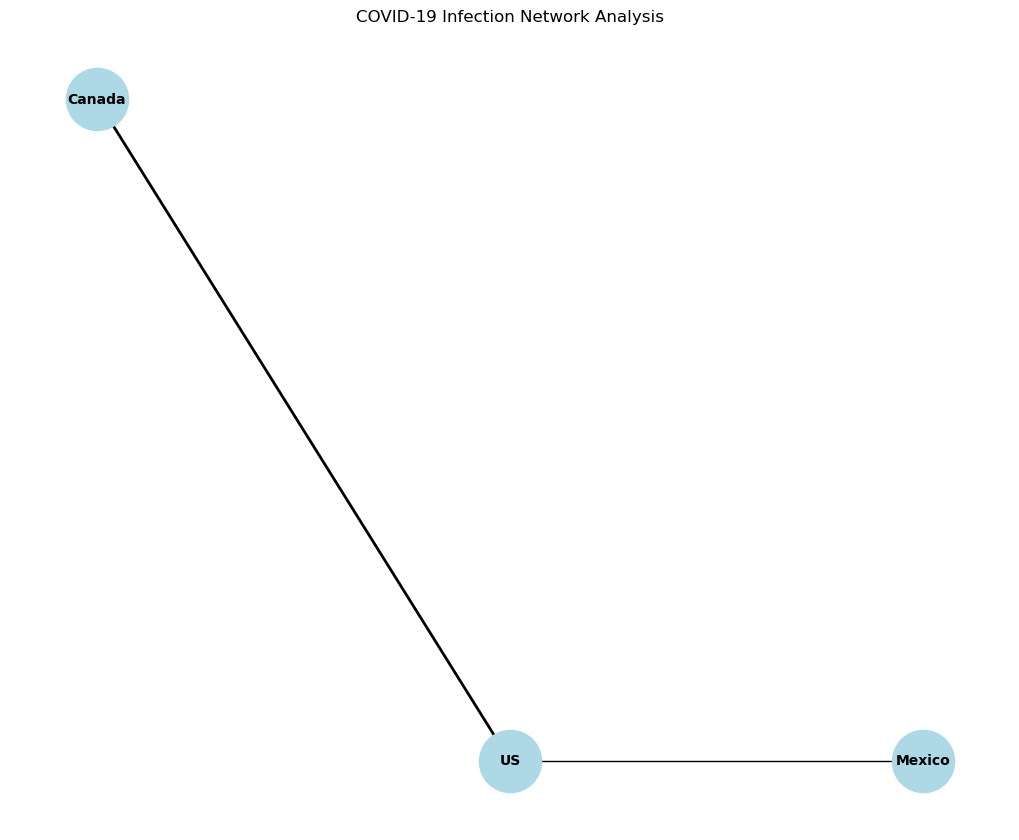

In [32]:
import networkx as nx
import numpy as np  # Make sure numpy is imported
import matplotlib.pyplot as plt

G = nx.Graph()

# Add nodes and positions
G.add_node(selected_country, pos=(0, 0))  # Center node

for i, neighbor in enumerate(neighboring_countries):
    angle = 2 * np.pi * i / len(neighboring_countries)  # Arrange neighbors in a circular layout
    G.add_node(neighbor, pos=(np.cos(angle), np.sin(angle)))
    G.add_edge(selected_country, neighbor, weight=0.5 * (i + 1))  # Assign edge weights

# Get positions
pos = nx.get_node_attributes(G, 'pos')

# Draw the graph
plt.figure(figsize=(10, 8))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color='lightblue',
    node_size=2000,
    font_size=10,
    font_weight='bold',
    width=[G[u][v]['weight'] * 2 for u, v in G.edges()]
)
plt.title("COVID-19 Infection Network Analysis")
plt.show()

## 4. Visualisation

### Linear Regression Analysis Visualization
Show the trend of COVID-19 infection rates over weeks for the top three countries.

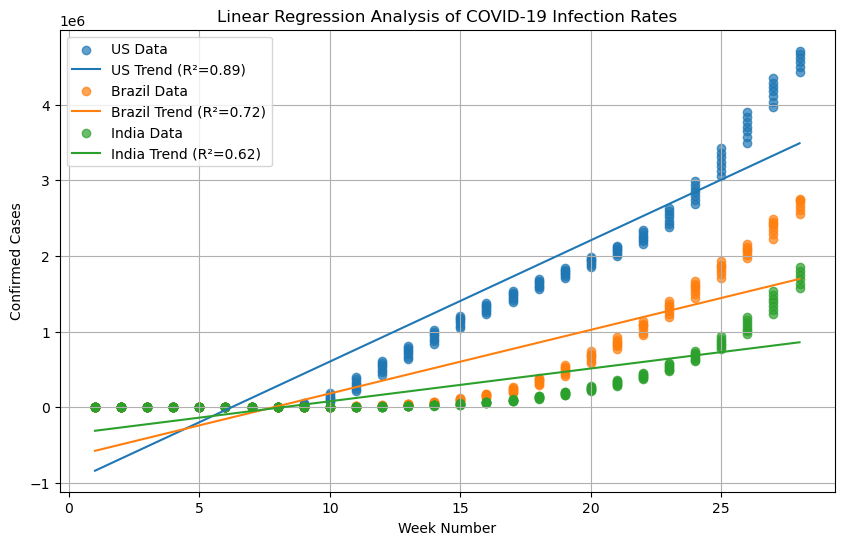

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for country in top_countries:
    country_data = df_grouped[df_grouped['Country/Region'] == country]
    model, metrics, country_data = fit_linear_regression(country, df_grouped)

    plt.scatter(country_data['Week'], country_data['Confirmed Cases'], label=f"{country} Data", alpha=0.7)
    plt.plot(country_data['Week'], model.predict(country_data['Week'].values.reshape(-1, 1)), 
             label=f"{country} Trend (R²={metrics['r2']:.2f})")

plt.title('Linear Regression Analysis of COVID-19 Infection Rates')
plt.xlabel('Week Number')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.grid()
plt.show()

### Clustering Analysis Visualization

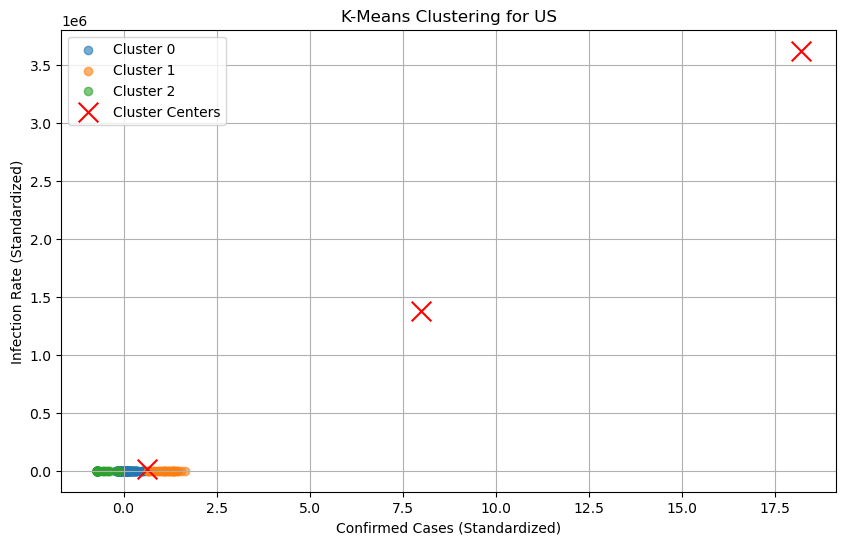

In [34]:
plt.figure(figsize=(10, 6))
for cluster in range(optimal_k):
    cluster_points = clustering_data[clustering_data['Cluster'] == cluster]
    plt.scatter(cluster_points['Infection Rate'], cluster_points['Confirmed Cases'], label=f"Cluster {cluster}", alpha=0.6)

plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], color='red', marker='x', s=200, label='Cluster Centers')
plt.title(f'K-Means Clustering for {selected_country}')
plt.xlabel('Confirmed Cases (Standardized)')
plt.ylabel('Infection Rate (Standardized)')
plt.legend()
plt.grid()
plt.show()

### Graph Analytics Visualization
Show relationships between the selected country and its neighbors based on weekly infection counts.


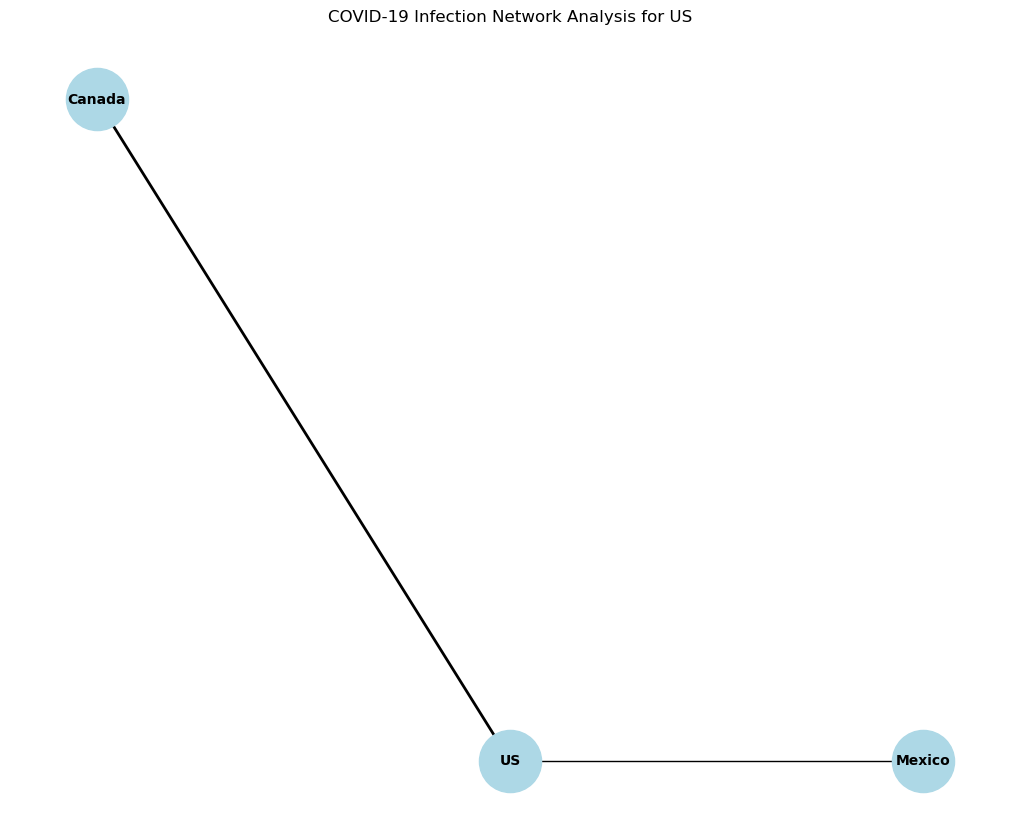

In [35]:
import networkx as nx

plt.figure(figsize=(10, 8))
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos,
        with_labels=True,
        node_color='lightblue',
        node_size=2000,
        font_size=10,
        font_weight='bold',
        width=[G[u][v]['weight'] * 2 for u, v in G.edges()])

plt.title(f"COVID-19 Infection Network Analysis for {selected_country}")
plt.show()